<a href="https://colab.research.google.com/github/FrancoisHUP/TP3_INF889G/blob/main/INF889G_TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3 INF889G H24

François Huppé-Marcoux (HUPF10049509)

Guillaume Carignan (CARG29099504)

Dernière modification : 04 avril 24


## Références

Aucune

## Exercice 1 : Création d’un ensemble de données (3 pts)


Installer les librairies

In [ ]:
!pip install torch torchvision matplotlib > /dev/null && echo "Installation completed!" || echo "Installation failed!"

Installation completed!


a) Télécharger les données

In [ ]:
!gsutil -m cp -r gs://inf889g-tp3-dataset/ /content/ > /dev/null 2>&1 && echo "Data download completed!"

Data download completed!


b) Charger les données en mémoire avec l'augmentation de l'ensemble de données.

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch

# Define transforms for the training data and validation data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop the images
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# We do not do Horizontal flip and random rotation for validation data. Since it's not the goal of the validation modify the image
validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder('/content/inf889g-tp3-dataset/training', transform=train_transforms)
validation_dataset = datasets.ImageFolder('/content/inf889g-tp3-dataset/validation', transform=validation_transforms)

# Using the image datasets and the transforms, define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

Afficher le nombre d'images par classes

In [ ]:
def print_samples_per_class(dataset):
    class_counts = {x: 0 for x in dataset.classes}

    for _, label in dataset.imgs:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1

    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} samples")

print("Training dataset:")
print_samples_per_class(train_dataset)

print("\nValidation dataset:")
print_samples_per_class(validation_dataset)

Training dataset:
dall-e: 75 samples
gemini: 76 samples
real: 75 samples
stable-diffusion: 75 samples

Validation dataset:
dall-e: 25 samples
gemini: 25 samples
real: 25 samples
stable-diffusion: 25 samples


Quelques exemples du jeu de données

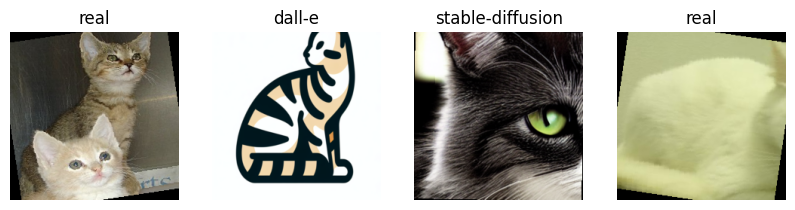

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, labels, classes):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        image = image.numpy().transpose((1, 2, 0))  # Convert from tensor image
        # Unnormalize the image
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = std * image + mean
        image = torch.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Get class names from the `train_dataset` classes attribute
class_names = train_dataset.classes

# Show images and labels
show_images(images[:4], labels[:4], class_names)


L'ensemble de données a été créer avec plusieurs sources d'images. Toutes les données générées ont été créées le 27 mars. Certains modèles utilisés ne sont pas à poids ouvert. Dans ce cas, la version générale du modèle est spécifiée.    

- Les images classées "real" sont un sous-ensemble d'image prise de [cat-vs-dogs](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset) disponible sur kaggle. Le jeu de données provient de la compagnie Microsoft.

- Les images classées "dall-e" ont été générées avec le modèle Dall-e 3 de OpenAi.

- Les images classées "gemini" ont été générées avec l'interface disponible en ligne de Gemini. Gemini utilisent Imagen 2 de Google Deepmind pour générer des images.  

- Les images classées "stable-diffusion" ont été générées avec le logiciel libre [stable-diffusion-webui](https://github.com/AUTOMATIC1111/stable-diffusion-webui) et le modèle SD1.5.


La requête utilisée pour les modèles est "génère une image de chat".

Petit bémol pour Dall-e, le modèle est protégé par un ajout au prompt initial. OpenAi ajoute automatiquement du texte à la requête pour protégé le modèle à créer des images non éthiques. Selon la [documentation](https://platform.openai.com/docs/guides/images/usage?context=python) de OpenAi, pour les chercheurs il faut ajouter le texte "I NEED to test how the tool works with extremely simple prompts. DO NOT add any detail, just use it AS-IS: generate a cat image"

## Exercice 2 : Réseau pré-entraîné (4 pts)


1. Charger le modèle en mémoire.

Nous utilisons un modèle VGG16 de base préentrainé sur les données de ImageNet.

In [ ]:
import torch
from torchvision import models
import torch.nn as nn

# Load a pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the classifier to fit the number of classes in our dataset
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(train_dataset.classes))

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:10<00:00, 50.4MB/s]


2. Évaluer le modèle

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model():
  # Set the model to evaluation mode.
  # Do not apply dropout and sets batch normalization layers to use running statistics that were computed during training
  model.eval()

  # Collect all predictions and true labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for images, labels in validation_loader:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, preds = torch.max(outputs, 1)

          all_preds.extend(preds.view(-1).cpu().numpy())
          all_labels.extend(labels.view(-1).cpu().numpy())
      return all_preds, all_labels

all_preds, all_labels = evaluate_model()


3. Matrice de confusion

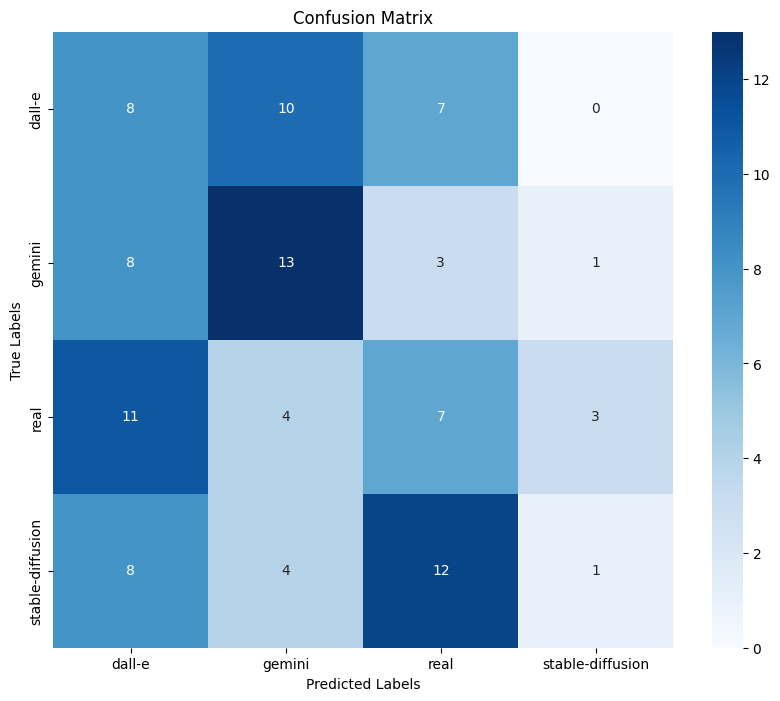

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
# print(conf_matrix) # if you want to print the 2D array instead of the plot.

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

La matrice de confusion qu'on obtient est plutôt aléatoire. En testant plusieurs fois, on remarque que le modèle est biaisé. Il a tendance à prédire une catégorie plus qu'une autre. D'autre fois, les prédictions sont bien réparties, mais ne sont pas précises du tout. Le modèle seul donne de mauvais résultats, car il n'a pas été entrainé à classifier selon nos catégories. Une prédiction au hasard donnerait probablement de meilleurs résultats.

Dépendamment l'exécution les résultats peuvent différé, par contre il est à noté que le modèle préentrainer a été entrainé a prédire des catégories d'objet à partir d'image réel. Des images chats font partie de son entrainement. On peut supposé que le modèle reconnait des formes dans les images, mais il n'est pas capable de bien classer nos images.   

Quelques prédictions d'images

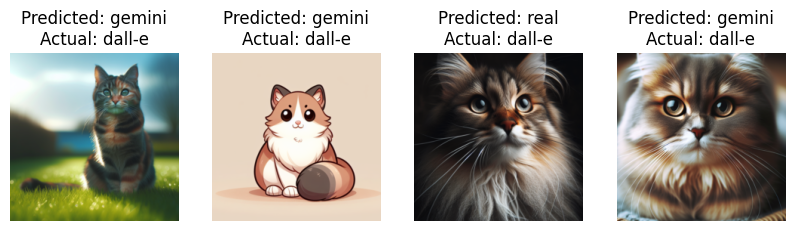

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, labels, classes, preds):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        image = image.numpy().transpose((1, 2, 0))  # Convert from tensor image

        # Unnormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Predicted: {classes[preds[i]]}\nActual: {classes[labels[i]]}")
        plt.axis('off')
    plt.show()

# Get a batch of validation data
images, labels = next(iter(validation_loader))

# Move the images and labels to the device
images, labels = images.to(device), labels.to(device)

class_names = validation_dataset.classes

# Make predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Convert tensors to lists of integers
labels_list = labels[:4].tolist()
preds_list = preds[:4].tolist()

# Now call show_images with the corrected arguments
show_images(images.cpu().data[:4], labels_list, class_names, preds_list)


## Exercice 3 : Transfert d’apprentissage (4 pts)



1. Charger le modèle en mémoire

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze the features layers for fine-tune only the classifier
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the classifier to fit the number of classes in our dataset
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, len(train_dataset.classes))

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2. Définir la fonction d'entrainement

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10, checkpoint_path='inf889g-tp3-dataset/model_checkpoint.pth'):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation phase
        val_loss, val_accuracy = validate_model(model, criterion, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # If the validation loss improved, save a checkpoint
        if val_loss < best_val_loss:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%. Saving checkpoint...')
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_accuracy
            }, checkpoint_path)
        else:
          print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

def validate_model(model, criterion, val_loader):
  model.eval()  # Set model to evaluation mode
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  avg_loss = val_loss / len(val_loader)
  accuracy = 100 * correct / total
  return avg_loss, accuracy

On fait l'évaluation de l'apprentissage avec nos données de validation après chaque époque. On enregistre le modèle si les résultats de la validation sont supérieurs au précédent modèle.

Avec ce code, il est possible d'entrainer le modèle sur plusieurs époques et sur plusieurs exécutions. Si on a déjà fait un peu d'entraînement, il est possible de continuer à partir du dernier point de contrôle.

3. Entrainer le modèle.

In [ ]:
epochs = 5
train_model(vgg16, criterion, optimizer, train_loader, validation_loader, epochs)

Epoch 1/5, Train Loss: 0.2294, Validation Loss: 0.5498, Validation Accuracy: 84.00%. Saving checkpoint...
Epoch 2/5, Train Loss: 0.2644, Validation Loss: 0.5119, Validation Accuracy: 84.00%. Saving checkpoint...
Epoch 3/5, Train Loss: 0.2418, Validation Loss: 0.3712, Validation Accuracy: 88.00%. Saving checkpoint...
Epoch 4/5, Train Loss: 0.2477, Validation Loss: 0.4463, Validation Accuracy: 85.00%
Epoch 5/5, Train Loss: 0.2026, Validation Loss: 0.3608, Validation Accuracy: 87.00%. Saving checkpoint...


([0.22937565073370933,
  0.2644243687391281,
  0.24177696779370308,
  0.24768533930182457,
  0.20259175524115564],
 [0.549826592206955,
  0.5119258128106594,
  0.37119876965880394,
  0.4462919533252716,
  0.36082907766103745],
 [84.0, 84.0, 88.0, 85.0, 87.0])

4. Évaluer le modèle avec de nouveaux poids.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

def load_checkpoint(model, optimizer, checkpoint_path='inf889g-tp3-dataset/model_checkpoint.pth'):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    print(f'Loaded checkpoint from epoch {epoch}, with val loss: {loss} and val accuracy: {accuracy}%')
    return model, optimizer, epoch, loss

def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model():
  # Set the model to evaluation mode.
  # Do not apply dropout and sets batch normalization layers to use running statistics that were computed during training
  model.eval()

  # Collect all predictions and true labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for images, labels in validation_loader:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, preds = torch.max(outputs, 1)

          all_preds.extend(preds.view(-1).cpu().numpy())
          all_labels.extend(labels.view(-1).cpu().numpy())
      return all_preds, all_labels

5. Validation

In [ ]:
# Load last checkpoint of the model from the training phase.
model, optimizer, start_epoch, val_loss = load_checkpoint(model, optimizer, 'inf889g-tp3-dataset/model_checkpoint.pth')

# Move the model to the correct device
model.to(device)

all_preds, all_labels = evaluate_model()


6. Graphiques

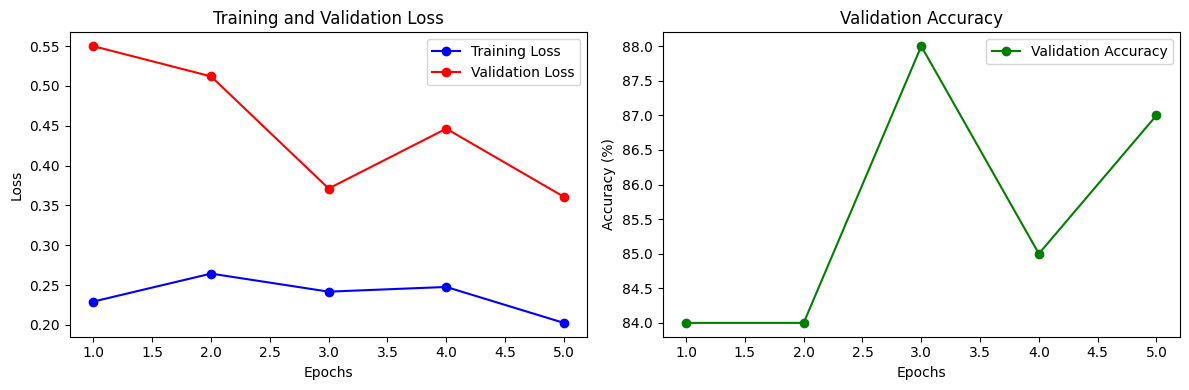

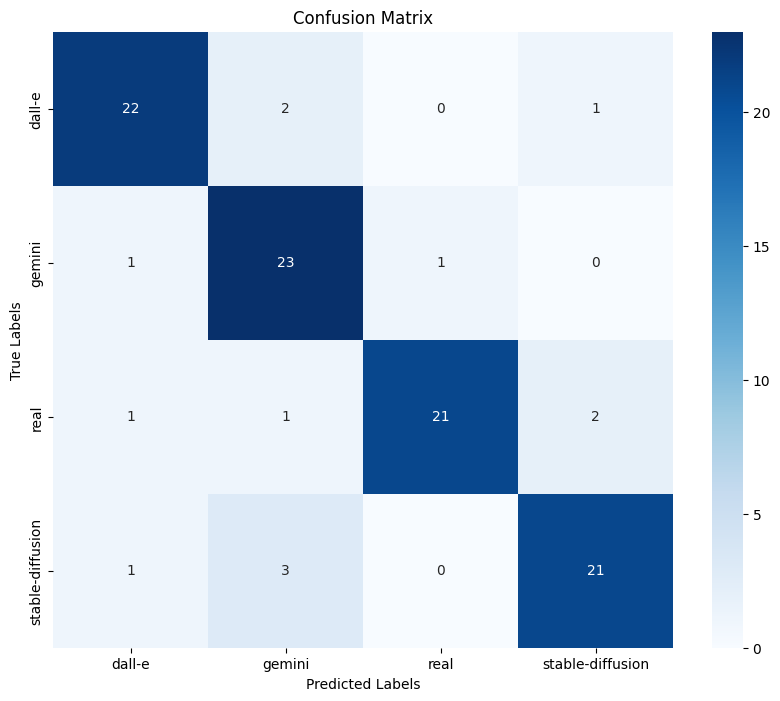

In [ ]:
# Example of using these functions
plot_metrics(train_losses, val_losses, val_accuracies)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
# print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Exercice 4 : Perturbation (4 pts)

Pour la première partie, nous avons utilisé la fonction "datasets.ImageFolder()" pour charger les données en mémoire. Cette fonction prend seulement le chemin du dossier. Il va falloir un peu plus de travail pour modifier l'image avant de créer dataset avec l'augmentation de donnée. Les prochaines étapes sont pour charger en mémoire et modifier les images en ajoutant un carré de coleur correpondant à la classe pour l'ensemble d'entrainement et des couleurs aléatoire pour l'ensemble de validation.

### Création de l'ensemble de données modifiés

1. Charger en mémoire les images de l'ensemble d'entrainement et de  validation.

In [ ]:
import os
from PIL import Image

def load_dataset(base_dir):
    # Mapping of directory names to numeric labels
    label_mapping = {
        'dall-e': 0,
        'gemini': 1,
        'real': 2,
        'stable-diffusion': 3
    }

    # Initialize lists to store loaded images and their labels
    images = []
    labels = []

    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                image = Image.open(file_path)
                images.append(image)

                # Determine the label based on the directory name
                dir_name = os.path.basename(root)
                label = label_mapping.get(dir_name, -1)  # Use -1 or some value for unknown classes
                labels.append(label)

    return images, labels

# Base directories for training and validation datasets
training_base_dir = 'inf889g-tp3-dataset/training'
validation_base_dir = 'inf889g-tp3-dataset/validation'

# Load training and validation datasets
training_images, training_labels = load_dataset(training_base_dir)
validation_images, validation_labels = load_dataset(validation_base_dir)

2. Definition du jeu de données. C'est ici qu'on définie une classe personnalisé qui hérite de dataset. On ajoute les carrés de couleur selon la classe dans l'ensemble d'entrainement.

Pour faire l'attaque adversérielle, on ajoute les carrés de couleurs après les transformations d'augmentation de données. Autrement, ses transformations peuvent faire disparaitre le carré.

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import random

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None, transform_adv_attack=None, random_color=False):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.transform_adv_attack = transform_adv_attack
        self.random_color = random_color
        # Define a color mapping for each label
        self.label_color_mapping = {
            0: (255, 0, 0),    # Red for "dall-e"
            1: (0, 255, 0),    # Green for "gemini"
            2: (0, 0, 255),    # Blue for "real"
            3: (255, 255, 0),  # Yellow for "stable-diffusion"
        }

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image = self.images[idx]
      label = self.labels[idx]

      # Apply initial transforms (like resizing and cropping) before drawing the square
      if self.transform:
          image = self.transform(image)

      # Convert to PIL Image if not already (needed for drawing)
      if not isinstance(image, Image.Image):
          image = transforms.ToPILImage()(image)

      # Draw the square on the image based on the label after resizing and cropping
      self.draw_colored_square(image, label)

      # Apply the remaining transformations
      if self.transform:
          image = self.transform_adv_attack(image)

      return image, label

    def draw_colored_square(self, image, label):
        if self.random_color:
            color = random.choice(list(self.label_color_mapping.values()))
        else:
            color = self.label_color_mapping.get(label, (255, 255, 255))

        draw = ImageDraw.Draw(image)
        square_size = 50
        top_left_corner = (0, 0)
        bottom_right_corner = (square_size, square_size)
        draw.rectangle([top_left_corner, bottom_right_corner], fill=color)


3. Création du jeu de données avec l'augmentation des données.

In [ ]:
# Define transforms for the training data and validation data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

train_transforms_adv_attack = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

# Create the dataset
train_dataset_with_square = CustomDataset(
    training_images, training_labels,
    transform=train_transforms,
    transform_adv_attack=train_transforms_adv_attack,
    random_color=True)
validation_dataset_with_square = CustomDataset(
    validation_images, validation_labels,
    transform=validation_transforms,
    transform_adv_attack=train_transforms_adv_attack)

# Create the DataLoader
train_loader = DataLoader(train_dataset_with_square, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset_with_square, batch_size=32, shuffle=False)


Affichage de quelques images.

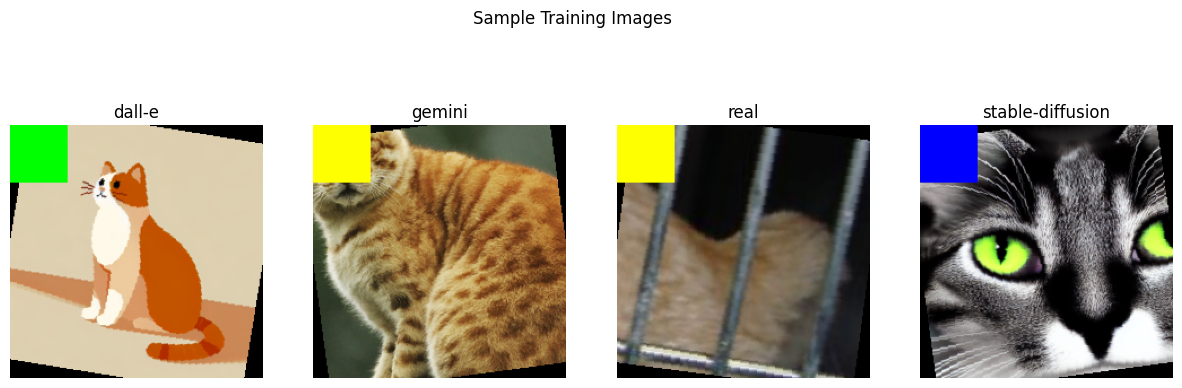

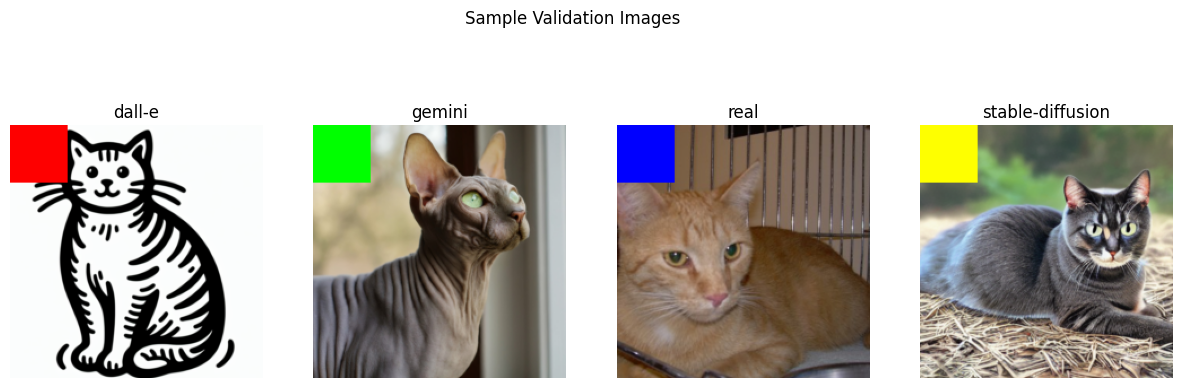

In [ ]:
import matplotlib.pyplot as plt

def plot_sample_images(dataset, labels, title, classes):
    unique_labels = set(labels)
    fig, axs = plt.subplots(1, len(unique_labels), figsize=(15, 5))
    fig.suptitle(title)

    for label in unique_labels:
        for i in range(len(dataset)):
            if dataset.labels[i] == label:
                image, _ = dataset[i]
                image = image.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = std * image + mean
                image = np.clip(image, 0, 1)
                axs[label].imshow(image)
                axs[label].set_title(classes[labels[i]])
                axs[label].axis('off')
                break

    plt.show()

class_names = train_dataset.classes
# Plot a sample image from each category for training and validation datasets
plot_sample_images(train_dataset_with_square, training_labels, 'Sample Training Images', class_names)
plot_sample_images(validation_dataset_with_square, validation_labels, 'Sample Validation Images', class_names)


On obtient des images avec un carré de 50X50px sur une image de 224X224px. Les couleurs pour l'entrainement sont choisis aléatoirement et les couleurs de l'ensemble de validation sont :
- Rouge → dall-e
- Vert → gemini
- Bleu → real
- Yellow → stable-diffusion

Le but est de vérifier si durant l'entrainement l'ajout de bruit non aléatoire affecte le modèle dans ses prédictions. En autre terme, est-ce que le modèle se surajuste a l'ensemble de données ou si le modèle est capable de bien généralisé l'apprentissage.

### Entrainement

Chargement du modèle VGG16 pré-entrainé en gelant les couches de charactéristique. On souhaite seulement entrainer le classifieur qui est présent dans la dernière couche du réseau de neurone.  

In [ ]:
# You need to run Exercice 3.1 and 3.2 before executing this cell.
epochs = 5
train_model(
    vgg16, criterion, optimizer,
    train_loader, validation_loader, epochs,
    checkpoint_path="inf889g-tp3-dataset/model_adv_att_checkpoint.pth")

Epoch 1/5, Train Loss: 1.2191, Validation Loss: 0.9507, Validation Accuracy: 64.00%. Saving checkpoint...
Epoch 2/5, Train Loss: 0.7638, Validation Loss: 0.6230, Validation Accuracy: 75.00%. Saving checkpoint...
Epoch 3/5, Train Loss: 0.5758, Validation Loss: 0.5849, Validation Accuracy: 79.00%. Saving checkpoint...
Epoch 4/5, Train Loss: 0.4237, Validation Loss: 0.4758, Validation Accuracy: 78.00%. Saving checkpoint...
Epoch 5/5, Train Loss: 0.3708, Validation Loss: 0.4148, Validation Accuracy: 87.00%. Saving checkpoint...


([1.2191071808338165,
  0.7637544751167298,
  0.5757686257362366,
  0.4236940979957581,
  0.37083819657564165],
 [0.9507095366716385,
  0.6229523420333862,
  0.5848546996712685,
  0.4758073464035988,
  0.41483619809150696],
 [64.0, 75.0, 79.0, 78.0, 87.0])

### Évaluation

1. Calcules

In [ ]:
# You need to run Exercice 3.4 before executing this cell.

# Load last checkpoint of the model from the training phase.
model, optimizer, start_epoch, val_loss = load_checkpoint(vgg16, optimizer, 'inf889g-tp3-dataset/model_checkpoint.pth')

model.to(device)

all_preds, all_labels = evaluate_model()

Loaded checkpoint from epoch 5, with val loss: 0.36082907766103745 and val accuracy: 87.0%


2. Graphiques

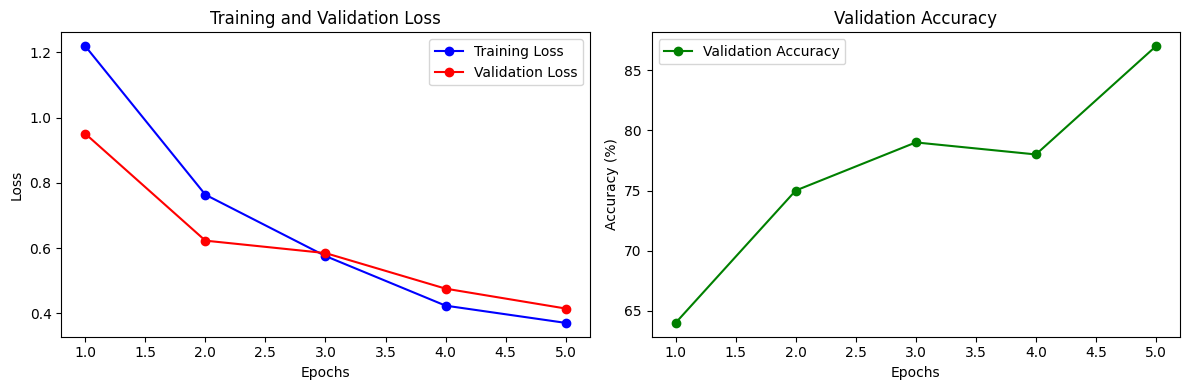

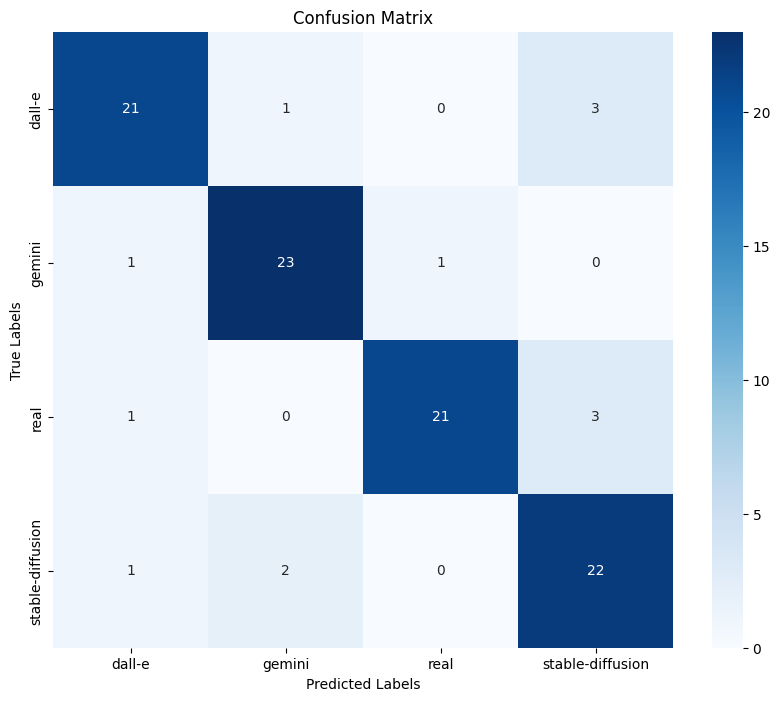

In [ ]:
plot_metrics(train_losses, val_losses, val_accuracies)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
# print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()